<a href="https://colab.research.google.com/github/icgc-argo/align-sklearn/blob/master/Align_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data and adds a column for **Speed per Core (SpC)**

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

DIR_ROOT = "/content/drive/My Drive/ML Models"

data = pd.read_csv(f'{DIR_ROOT}/Aligns.tsv', sep='\t')
data = data.drop(['Rate', 'Rate per CPU'], axis=1)
data['SpC'] = data['Size (bytes)'] / data['Time (milliseconds)'] / data['CPUs']
data

,Size (bytes),Time (milliseconds),CPUs,SpC
0,8700009668,9172428,12,79.041319
1,2521629446,1380985,12,152.163700
2,23824955442,21778458,12,91.164074
3,22553822274,21643542,12,86.838152
4,8700009668,7131083,16,76.250775
...,...,...,...,...
986,25981022300,9002437,36,80.166633
987,31809483361,11322848,36,78.036618
988,26743473608,10137015,36,73.283335
989,24567640970,10941586,36,62.370709


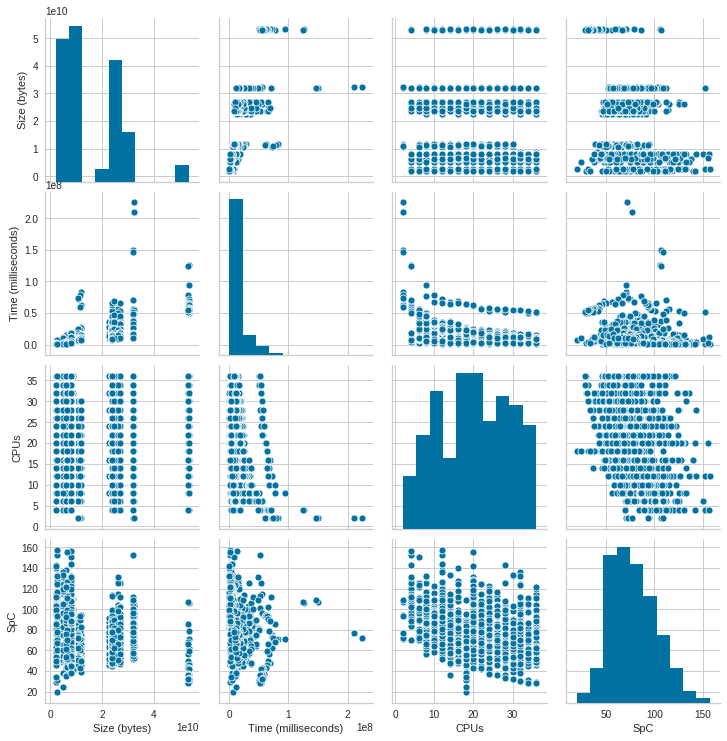

In [52]:
sns.pairplot(data)

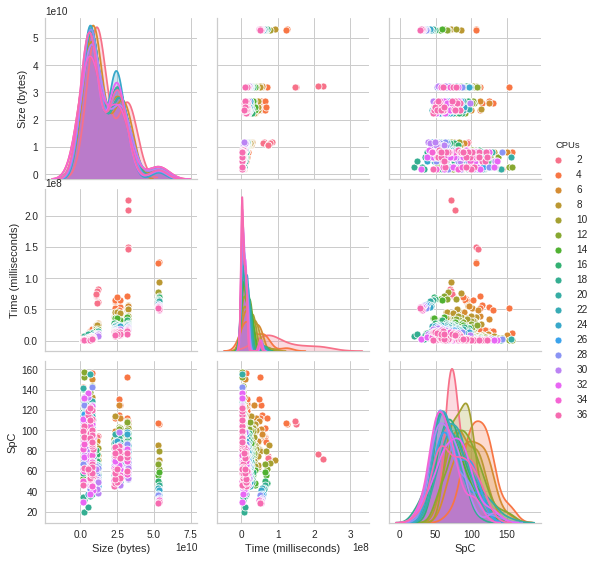

In [53]:
sns.pairplot(data, hue='CPUs')

# SpC Model

We first create a Speed per Core (SpC) estimation model to predict per-core performance

Speed per core (or `SpC`) is computed as `'Size (bytes)' / 'Time (milliseconds)' / 'CPUs'`

In [109]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.feature_selection import chi2

poly = PolynomialFeatures(2)

def createSpcModel():
  X = data[['Size (bytes)', 'CPUs']]
  y = data['SpC']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
  
  # we use an elastic net model to regularize the extra features created by PolynomialFeatures
  model = linear_model.ElasticNet(random_state=0)
  # model = linear_model.LassoLars(alpha=0.0)
  # model = linear_model.LinearRegression()
  model.fit(poly.fit_transform(X_train), y_train)

  test_features = poly.fit_transform(X_test)
  print("spcModel test R^2: ", model.score(test_features, y_test))
  print('Coefficients: ', model.coef_)
  test_predictions = model.predict(test_features)
  return model

spcModel = createSpcModel()

spcModel test R^2:  0.20896668729630008
Coefficients:  [ 0.00000000e+00 -3.53870165e-10 -2.32950502e+00  6.40991189e-21
 -2.57525781e-11  4.42990908e-02]


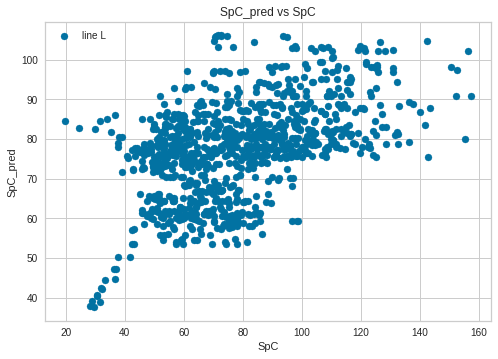

In [110]:
X = data[['Size (bytes)', 'CPUs']]
data['SpC_pred'] = spcModel.predict(poly.fit_transform(X))
# data['SpC_pred'] = spcModel.predict(data[['Size (bytes)', 'CPUs']])

def SpC_prediction_observation_plot():
  import matplotlib.pyplot as plt
  x = data['SpC']
  y = (data['SpC_pred'])
  plt.scatter(x, y, label="line L")
  plt.plot()

  plt.xlabel("SpC")
  plt.ylabel("SpC_pred")
  plt.title("SpC_pred vs SpC")
  plt.legend()
  plt.show()

SpC_prediction_observation_plot()


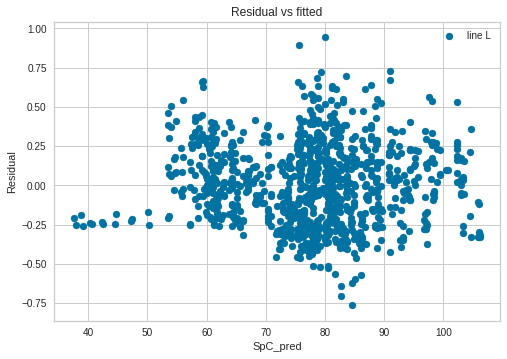

In [111]:
def SpC_residual_plot():
  import matplotlib.pyplot as plt
  x = data['SpC_pred']
  y = (data['SpC'] - data['SpC_pred']) / data['SpC_pred']
  plt.scatter(x, y, label="line L")
  plt.plot()

  plt.xlabel("SpC_pred")
  plt.ylabel("Residual")
  plt.title("Residual vs fitted")
  plt.legend()
  plt.show()

SpC_residual_plot()

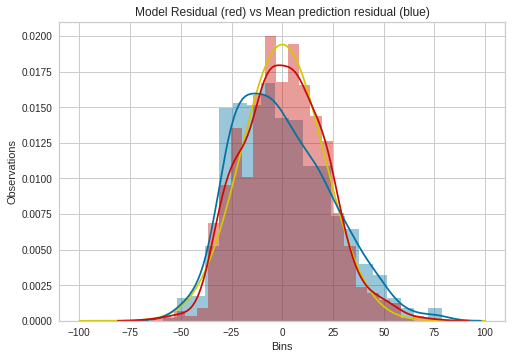

In [112]:
def SpC_residual_histogram():
  from scipy.stats import norm
  dist = (data['SpC'] - data['SpC_pred'])
  mean_dist = (data['SpC'] - data['SpC'].mean())

  import seaborn as sns
  from scipy.stats import norm
  from scipy import stats
  xx = np.arange(-100, +100, 0.001)
  std_normal = stats.norm.pdf(xx, scale = dist.std())
  plt.plot(xx, std_normal, 'y')
  sns.distplot(mean_dist, color="b")
  sns.distplot(dist, color="r")

  plt.xlabel("Bins")
  plt.ylabel("Observations")
  plt.title("Model Residual (red) vs Mean prediction residual (blue)")

SpC_residual_histogram()


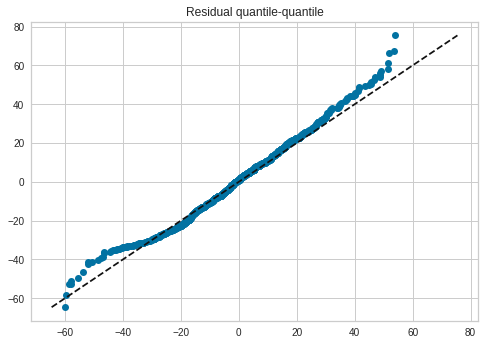

In [113]:

def SpC_residual_quantile_quantile():
  import numpy as np
  import matplotlib.pyplot as plt

  residuals = (data['SpC'] - data['SpC_pred'])

  a = np.random.normal(residuals.mean(),residuals.std(),len(residuals))
  b = residuals

  percs = np.linspace(0,100,len(residuals))
  qn_a = np.percentile(a, percs)
  qn_b = np.percentile(b, percs)

  plt.plot(qn_a,qn_b, ls="", marker="o")

  x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
  plt.plot(x,x, color="k", ls="--")
  plt.title("Residual quantile-quantile")
  plt.show()

SpC_residual_quantile_quantile()

# Time estimation

use the SpC prediction from above model to predict time

To account for any variation unaccount-ed for by SpC, we can use a arbitrary n-degree polynomial with degreen `poly_n` to give ultimate time prediction given a `SpC_implied_time` ( computed as `Size (bytes) / (SpC_pred * CPUs)`) with elastic net regularization to remove insignificant features. This step however should be unnecessary.

In [114]:
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report, r2_score

data['SpC_implied_time'] = data['Size (bytes)'] / (data['SpC_pred'] * data['CPUs'])
poly_n = 3
timePoly = PolynomialFeatures(poly_n)

def TimeModel():
  from sklearn import linear_model
  X = data[['SpC_implied_time']]
  y = data['Time (milliseconds)']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
  
  model = linear_model.ElasticNet(random_state=0)
  model.fit(timePoly.fit_transform(X_train), y_train)

  print("TimeModel test R^2: ", model.score(timePoly.fit_transform(X_test), y_test))
  return model

timeModel = TimeModel()

data['Time_est'] = timeModel.predict(timePoly.fit_transform(data[['SpC_implied_time']]))
data

TimeModel test R^2:  0.9145942116689739


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5579443836888061.0, tolerance: 16264630788373.172
  positive)


,Size (bytes),Time (milliseconds),CPUs,SpC,SpC_pred,SpC_implied_time,Time_est,cpu_est
0,8700009668,9172428,12,79.041319,87.323764,8.302446e+06,8.830762e+06,12
1,2521629446,1380985,12,152.163700,90.975009,2.309819e+06,2.582281e+06,18
2,23824955442,21778458,12,91.164074,80.450702,2.467863e+07,2.583194e+07,16
3,22553822274,21643542,12,86.838152,80.915450,2.322777e+07,2.433218e+07,16
4,8700009668,7131083,16,76.250775,82.071051,6.625364e+06,7.082942e+06,16
...,...,...,...,...,...,...,...,...
986,25981022300,9002437,36,80.166633,58.776324,1.227867e+07,1.297099e+07,36
987,31809483361,11322848,36,78.036618,53.469330,1.652530e+07,1.738541e+07,34
988,26743473608,10137015,36,73.283335,58.057330,1.279553e+07,1.350871e+07,36
989,24567640970,10941586,36,62.370709,60.128860,1.134953e+07,1.200406e+07,36


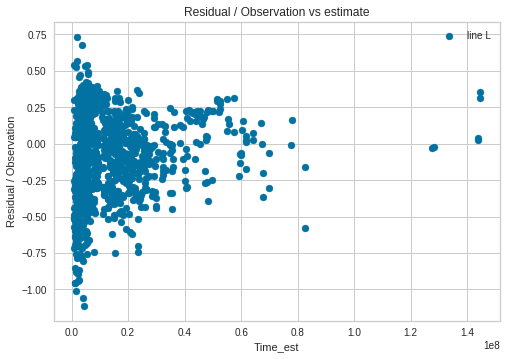

In [115]:
def residualPlot():
  import matplotlib.pyplot as plt
  x = data['Time_est']
  y = (data['Time (milliseconds)'] - data['Time_est']) / data['Time (milliseconds)']
  plt.scatter(x, y, label="line L")
  plt.plot()

  plt.xlabel("Time_est")
  plt.ylabel("Residual / Observation")
  plt.title("Residual / Observation vs estimate")
  plt.legend()
  plt.show()

residualPlot()

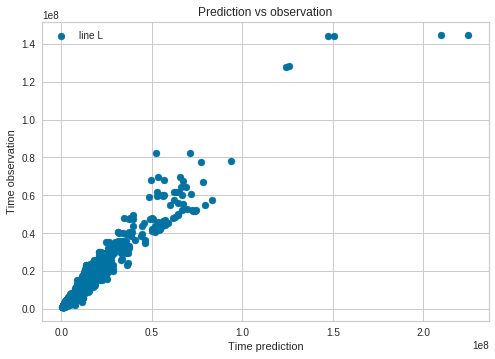

In [116]:
def predictionPlot():
  import matplotlib.pyplot as plt
  x = data['Time (milliseconds)']
  y = data['Time_est']
  plt.scatter(x, y, label="line L")
  plt.plot()

  plt.xlabel("Time prediction")
  plt.ylabel("Time observation")
  plt.title("Prediction vs observation")
  plt.legend()
  plt.show()

predictionPlot()

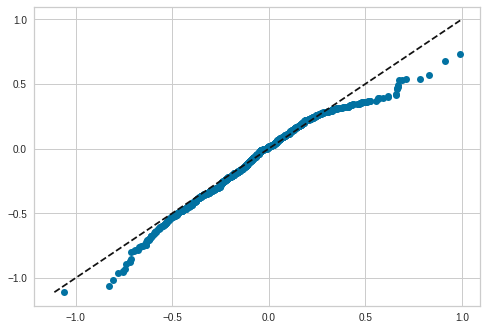

In [117]:
def time_residual_quantile_quantile():
  import numpy as np
  import matplotlib.pyplot as plt

  residuals = (data['Time (milliseconds)'] - data['Time_est']) / data['Time (milliseconds)']

  a = np.random.normal(residuals.mean(),residuals.std(),len(residuals))
  b = residuals

  percs = np.linspace(0,100,len(residuals))
  qn_a = np.percentile(a, percs)
  qn_b = np.percentile(b, percs)

  plt.plot(qn_a,qn_b, ls="", marker="o")

  x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
  plt.plot(x,x, color="k", ls="--")

  plt.show()

time_residual_quantile_quantile()

In [118]:
print("R^2: ", r2_score(data['Time (milliseconds)'], data['Time_est']))

R^2:  0.9223813569540185


For practical use, we want to be able to predict a 8-hour job within 1-hour with a 95% confidence. That means we are targetting a normalized residual computed as `(Time (milliseconds) - Time_est) / Time (milliseconds)` to be 12.7%. This is implies a normal distribution of normalize residual with 95% confidence interval being `[-0.127, 0.127]` (, which is equivalent to a distribution with a standard deviation of `0.127 / 1.96` (`target 95% confidence / t_value of 95%`).

The below chart shows the model's residual distribution (blue) compared to a simulated normal distribution with same std (red) and the target normal distribution of with std of `0.065`.

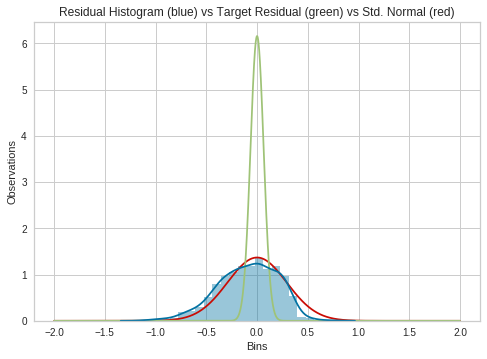

In [119]:
def residualHistogram():
  dist = (data['Time (milliseconds)'] - data['Time_est']) / data['Time (milliseconds)']

  import seaborn as sns
  from scipy.stats import norm
  from scipy import stats
  xx = np.arange(-2, +2, 0.001)
  std_normal = stats.norm.pdf(xx, scale = dist.std())
  target_normal = stats.norm.pdf(xx, scale = 0.127/1.96)
  plt.plot(xx, std_normal, 'r')
  plt.plot(xx, target_normal, 'g')
  sns.distplot(dist, color="b")

  plt.xlabel("Bins")
  plt.ylabel("Observations")
  plt.title("Residual Histogram (blue) vs Target Residual (green) vs Std. Normal (red)")

residualHistogram()

# CPU Estimate

In [120]:
# data['cpu_est'] = 

cpu_range = range(2, 38, 2)

def mapper(entry):
  def estimate_time(cpu):
    spc_prediction = spcModel.predict(poly.fit_transform([[entry['Size (bytes)'], cpu]]))[0]
    time_prediction = entry['Size (bytes)'] / (cpu*spc_prediction)
    return time_prediction
  return min(
    [
      {
        'cpu': cpu,
        'time_residual': (estimate_time(cpu) - entry['Time (milliseconds)'])**2,
      } for cpu in cpu_range
    ],
    key=lambda x: (x['time_residual'])
  )['cpu']

data['cpu_est'] = data[['Size (bytes)', 'Time (milliseconds)']].apply(mapper, axis=1)

data

,Size (bytes),Time (milliseconds),CPUs,SpC,SpC_pred,SpC_implied_time,Time_est,cpu_est
0,8700009668,9172428,12,79.041319,87.323764,8.302446e+06,8.830762e+06,10
1,2521629446,1380985,12,152.163700,90.975009,2.309819e+06,2.582281e+06,22
2,23824955442,21778458,12,91.164074,80.450702,2.467863e+07,2.583194e+07,14
3,22553822274,21643542,12,86.838152,80.915450,2.322777e+07,2.433218e+07,14
4,8700009668,7131083,16,76.250775,82.071051,6.625364e+06,7.082942e+06,14
...,...,...,...,...,...,...,...,...
986,25981022300,9002437,36,80.166633,58.776324,1.227867e+07,1.297099e+07,36
987,31809483361,11322848,36,78.036618,53.469330,1.652530e+07,1.738541e+07,36
988,26743473608,10137015,36,73.283335,58.057330,1.279553e+07,1.350871e+07,36
989,24567640970,10941586,36,62.370709,60.128860,1.134953e+07,1.200406e+07,36


In [121]:
from sklearn.metrics import r2_score
print(r2_score(data['CPUs'], data['cpu_est']))

0.5677659346396081


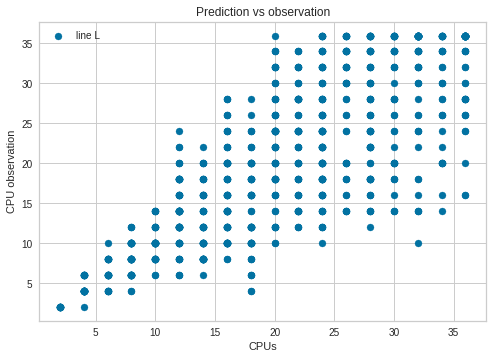

In [122]:
def cpuPredictionPlot():
  import matplotlib.pyplot as plt
  x = data['CPUs']
  y = data['cpu_est']
  plt.scatter(x, y, label="line L")
  plt.plot()

  plt.xlabel("CPUs")
  plt.ylabel("CPU observation")
  plt.title("Prediction vs observation")
  plt.legend()
  plt.show()

cpuPredictionPlot()

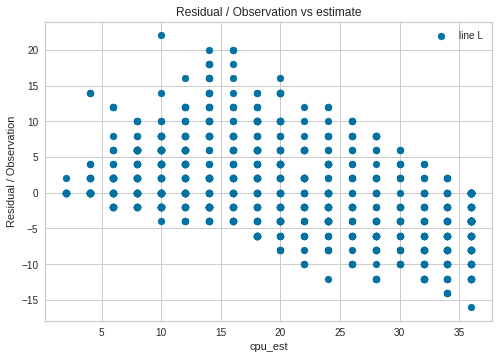

In [123]:
def cpu_residual_plot():
  import matplotlib.pyplot as plt
  x = data['cpu_est']
  y = (data['CPUs'] - data['cpu_est'])
  plt.scatter(x, y, label="line L")
  plt.plot()

  plt.xlabel("cpu_est")
  plt.ylabel("Residual / Observation")
  plt.title("Residual / Observation vs estimate")
  plt.legend()
  plt.show()

cpu_residual_plot()

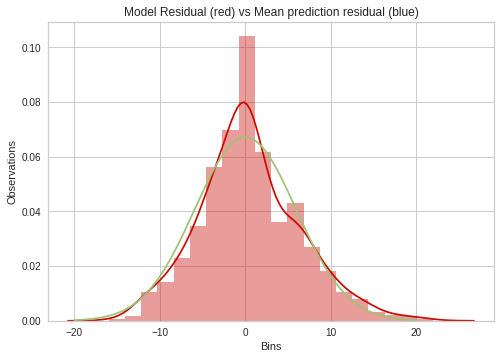

In [139]:
def cpu_residual_distribution():
  import matplotlib.pyplot as plt
  from scipy.stats import norm
  
  dist = (data['CPUs'] - data['cpu_est'])

  import seaborn as sns
  from scipy.stats import norm
  from scipy import stats
  xx = np.arange(-20, +20, 0.001)
  std_normal = stats.norm.pdf(xx, scale = dist.std())
  sns.distplot(dist, color="r", bins=20)
  plt.plot(xx, std_normal, 'g')

  plt.xlabel("Bins")
  plt.ylabel("Observations")
  plt.title("Model Residual (red) vs Mean prediction residual (blue)")

cpu_residual_distribution()

# Model output

In [0]:
from joblib import dump, load

dump(spcModel, f'{DIR_ROOT}/spc.joblib')
data.to_csv(f'{DIR_ROOT}/Aligns_out.tsv', sep='\t')